# Import

In [81]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, HalvingGridSearchCV
from sklearn.feature_selection import chi2
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

In [82]:
movies_df = pd.read_csv('../data/movies.csv')

# EDA and Preprocessing

In [83]:
credits_df.head()

,id,title,cast,crew
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,206647,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,49026,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,49529,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


In [84]:
movies_df.columns

Index(['index', 'budget', 'genres', 'homepage', 'id', 'keywords',
       'original_language', 'original_title', 'overview', 'popularity',
       'production_companies', 'production_countries', 'release_date',
       'revenue', 'runtime', 'spoken_languages', 'status', 'tagline', 'title',
       'vote_average', 'vote_count', 'cast', 'crew', 'director'],
      dtype='object')

In [85]:
C = movies_df['vote_average'].mean()
m = movies_df['vote_count'].quantile(0.9)

qualified_movies = movies_df.copy().loc[movies_df['vote_count'] >= m]
qualified_movies.shape

(481, 24)

In [86]:
def weighted_rating(x, m=m, C=C):
    v = x['vote_count']
    R = x['vote_average']
    # Calculation based on the IMDB formula
    return (v/(v+m) * R) + (m/(m+v) * C)

In [87]:
qualified_movies['score'] = qualified_movies.apply(weighted_rating, axis=1)

In [88]:
qualified_movies = qualified_movies.sort_values('score', ascending=False)

qualified_movies[['title', 'vote_count', 'vote_average', 'score']].head(10)

,title,vote_count,vote_average,score
1881,The Shawshank Redemption,8205,8.5,8.059258
662,Fight Club,9413,8.3,7.939256
65,The Dark Knight,12002,8.2,7.920020
3232,Pulp Fiction,8428,8.3,7.904645
96,Inception,13752,8.1,7.863239
3337,The Godfather,5893,8.4,7.851236
95,Interstellar,10867,8.1,7.809479
809,Forrest Gump,7927,8.2,7.803188
329,The Lord of the Rings: The Return of the King,8064,8.1,7.727243
1990,The Empire Strikes Back,5879,8.2,7.697884


Text(0.5, 1.0, 'Popular Movies')

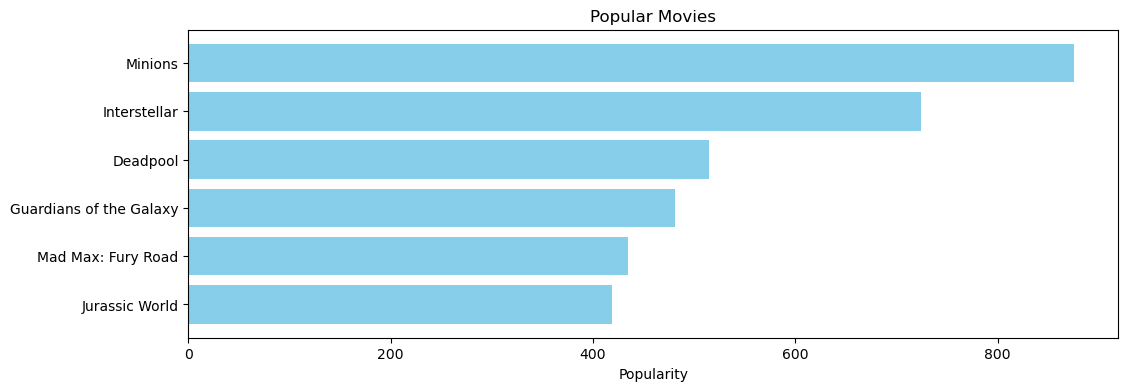

In [90]:
pop = movies_df.sort_values('popularity', ascending=False)
import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))

plt.barh(pop['title'].head(6),pop['popularity'].head(6), align='center',
        color='skyblue')
plt.gca().invert_yaxis()
plt.xlabel("Popularity")
plt.title("Popular Movies")


In [91]:
movies_df['overview'].head(5)

0    In the 22nd century, a paraplegic Marine is di...
1    Captain Barbossa, long believed to be dead, ha...
2    A cryptic message from Bond’s past sends him o...
3    Following the death of District Attorney Harve...
4    John Carter is a war-weary, former military ca...
Name: overview, dtype: object

In [92]:
movies_df.isnull().sum()

index                      0
budget                     0
genres                    28
homepage                3091
id                         0
keywords                 412
original_language          0
original_title             0
overview                   3
popularity                 0
production_companies       0
production_countries       0
release_date               1
revenue                    0
runtime                    2
spoken_languages           0
status                     0
tagline                  844
title                      0
vote_average               0
vote_count                 0
cast                      43
crew                       0
director                  30
dtype: int64

# Model

In [95]:
selected_features = ['genres','keywords','tagline','cast', 'director']

In [96]:
for feature in selected_features:
    movies_df[feature] = movies_df[feature].fillna('')

In [98]:
combined_features = movies_df['genres'] + ' ' + movies_df ['keywords'] + ' ' + movies_df ['tagline'] + ' ' + movies_df ['cast'] + ' ' + movies_df['director']

In [99]:
print(combined_features)

0       Action Adventure Fantasy Science Fiction cultu...
1       Adventure Fantasy Action ocean drug abuse exot...
2       Action Adventure Crime spy based on novel secr...
3       Action Crime Drama Thriller dc comics crime fi...
4       Action Adventure Science Fiction based on nove...
                              ...                        
4798    Action Crime Thriller united states\u2013mexic...
4799    Comedy Romance  A newlywed couple's honeymoon ...
4800    Comedy Drama Romance TV Movie date love at fir...
4801      A New Yorker in Shanghai Daniel Henney Eliza...
4802    Documentary obsession camcorder crush dream gi...
Length: 4803, dtype: object


In [100]:
vectorizer = TfidfVectorizer()

In [101]:
feature_vectors = vectorizer.fit_transform(combined_features)

# Saving Model

In [104]:
import joblib

In [105]:
joblib.dump(feature_vectors, 'feature_extraction.pkl')

['feature_extraction.pkl']